# Exploring Amazon Bedrock-Claude Sonnet's Multi-Modal Capabilities

This notebook explores Sonnet's multi-modal capabilities through the following use cases:
OCR - Simple text extraction and extraction from nested structures
Diagram analysis - Interpreting architectural diagrams, industrial piping and equipment diagrams, and analyzing chemical properties through charts - comparing molar mass versus boiling points and some fictitious organic compounds to demonstrate its capabilities beyond its training data
Predictive maintenance - Detecting dents and repairs in cars from images
Multi-modal RAG (Retrieval-Augmented Generation) - Allowing users to supply both text and images as input for querying, comparing, and analyzing data

In [ ]:
!pip install boto3 --upgrade

In [ ]:
!pip install chromadb

## Restart Kernel

In [ ]:
#Restart Kernel after the installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from utils import *

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
import json, os, sys
import io, base64
from matplotlib.pyplot import imshow
from PIL import Image

In [3]:
#Check if requried models are enabled in the account
[model for model in bedrock.list_foundation_models()["modelSummaries"] if model['modelId'] == claude_sonnet_model_id or model['modelId'] == titan_embed_model_id]

[{'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-embed-image-v1',
  'modelId': 'amazon.titan-embed-image-v1',
  'modelName': 'Titan Multimodal Embeddings G1',
  'providerName': 'Amazon',
  'inputModalities': ['TEXT', 'IMAGE'],
  'outputModalities': ['EMBEDDING'],
  'customizationsSupported': [],
  'inferenceTypesSupported': ['ON_DEMAND'],
  'modelLifecycle': {'status': 'ACTIVE'}},
 {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/anthropic.claude-3-sonnet-20240229-v1:0',
  'modelId': 'anthropic.claude-3-sonnet-20240229-v1:0',
  'modelName': 'Claude 3 Sonnet',
  'providerName': 'Anthropic',
  'inputModalities': ['TEXT', 'IMAGE'],
  'outputModalities': ['TEXT'],
  'responseStreamingSupported': True,
  'customizationsSupported': [],
  'inferenceTypesSupported': ['ON_DEMAND'],
  'modelLifecycle': {'status': 'ACTIVE'}}]

In [44]:
import IPython
def show_img(image_path):
    IPython.display.display(IPython.display.Image(filename=image_path,width=600,height=600))
def print_md(txt):
    IPython.display.display(IPython.display.Markdown(txt))

## Evaluate a simple text prompt for the model

In [161]:
prompt = """Command: Write an overview on abrasives, body fillers, glazes used for auto repair.\Overview:"""
invoke_claude_sonnet(prompt)

"Abrasives, body fillers, and glazes are essential components used in the automotive repair industry for surface preparation, filling, and finishing tasks. Here's an overview of these materials:\n\n1. Abrasives:\nAbrasives are materials used for sanding, grinding, or polishing surfaces. They come in various forms, including sandpapers, grinding discs, and polishing compounds. Abrasives play a crucial role in removing scratches, rust, old paint, or other surface imperfections before applying new coatings or fillers.\n\n2. Body Fillers:\nBody fillers, also known as automotive putties or glazing compounds, are two-component (resin and hardener) materials used to fill dents, scratches, and other imperfections on the body panels of vehicles. They are designed to provide a smooth surface for subsequent painting or finishing operations. Body fillers come in different types, such as lightweight, heavy-duty, or fiberglass-reinforced variants, depending on the specific application and desired st

## OCR capabilities

This section we will evaluate the OCR capabilities of the model. We will extract content from a page in user manual and auto repair service advice document.

We will extract recommended tire pressure levels and lit of recommendations by the service center.

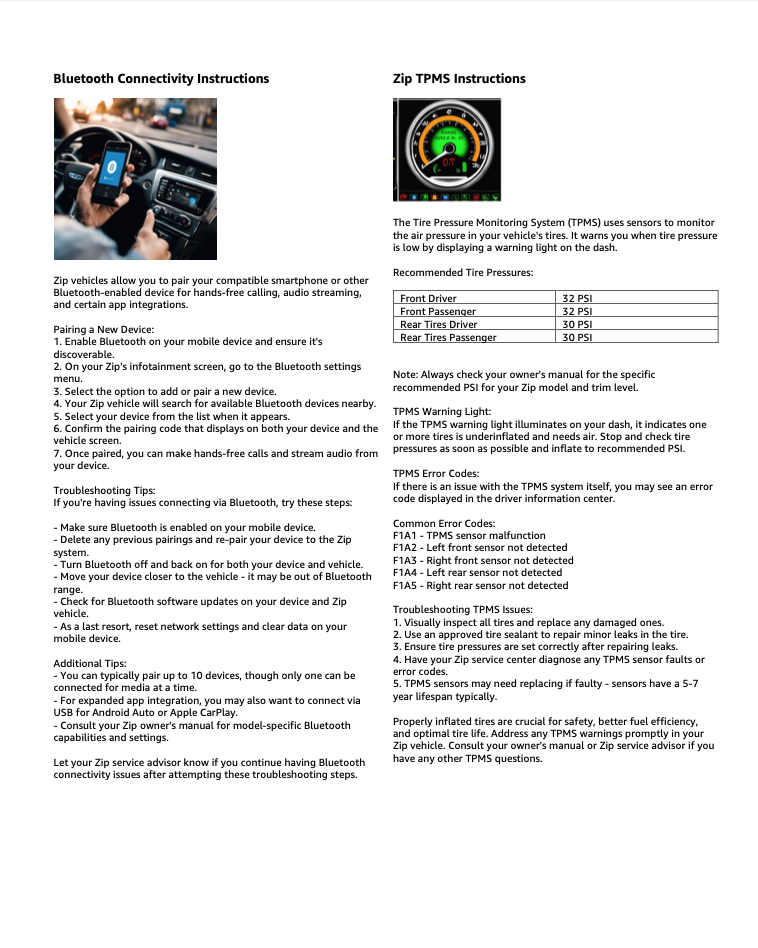

In [68]:
show_img("images/zip_manual.png")

In [69]:
prompt = """
What is the recommended tire pressure levels? Format output as a markdown table.
"""
print_md(invoke_claude_sonnet(prompt,"images/zip_manual.png"))

The recommended tire pressure levels are provided in the image as a table. Here is the markdown table:

| Tire | Recommended Pressure (PSI) |
|------|----------------------------|
| Front Driver | 32 PSI |
| Front Passenger | 32 PSI |
| Rear Tire Driver | 30 PSI | 
| Rear Tire Passenger | 30 PSI |

Note: The image mentions to always check your owner's manual for the specific recommended PSI for your Zip model and trim level.

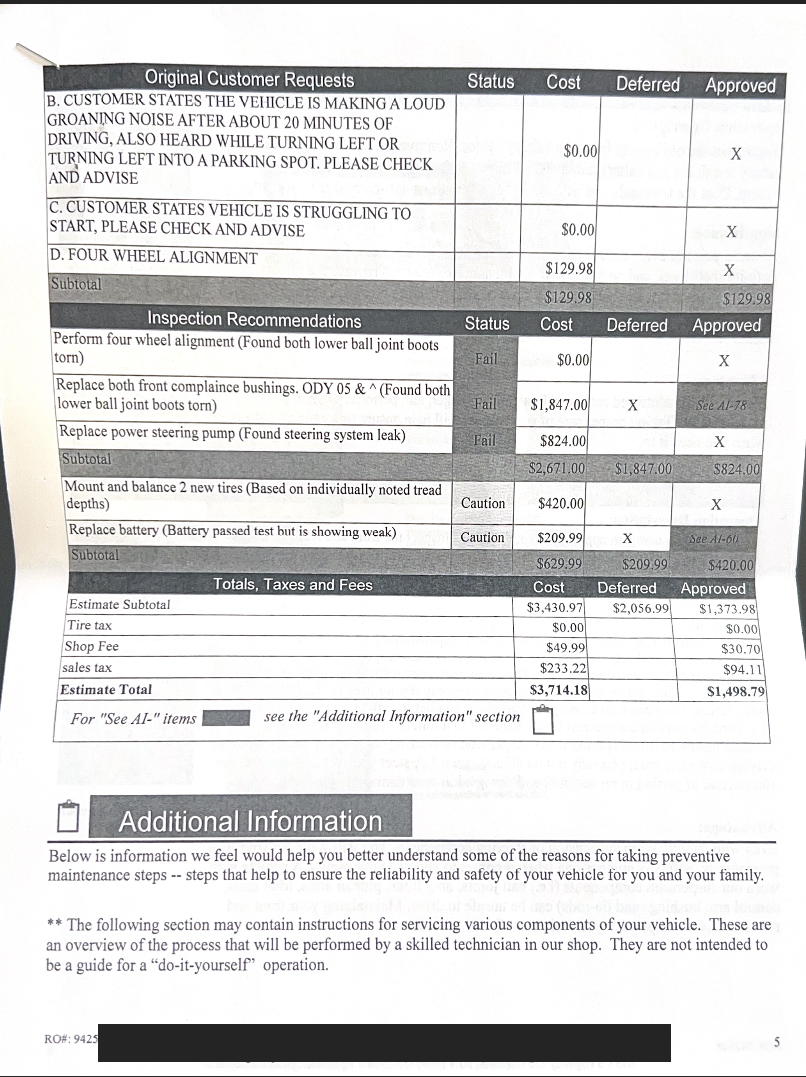

In [84]:
show_img("images/auto_repair_advice.png")

In [91]:
prompt = """
List original customer requests and their cost. Also list caution items. Format output as markdown.
"""
print_md(invoke_claude_sonnet(prompt,"images/auto_repair_advice.png"))

```markdown
Original Customer Requests:
- B. CUSTOMER STATES THE VEHICLE IS MAKING A LOUD GROANING NOISE AFTER ABOUT 20 MINUTES OF DRIVING, ALSO HEARD WHILE TURNING LEFT OR TURNING LEFT INTO A PARKING SPOT, PLEASE CHECK AND ADVISE: Cost $0.00, Approved
- C. CUSTOMER STATES VEHICLE IS STRUGGLING TO START, PLEASE CHECK AND ADVISE: Cost $0.00, Approved
- D. FOUR WHEEL ALIGNMENT: Cost $129.98, Approved

Inspection Recommendations:
- Perform four wheel alignment (Found both lower ball joint boots torn): Cost $0.00, Approved
- Replace both front compliance bushings, ODY 05 & ^ (Found both lower ball joint boots torn): Cost $1,847.00, Deferred (See AI-76)
- Replace power steering pump (Found steering system leak): Cost $824.00, Approved

Caution Items:
- Mount and balance 2 new tires (Based on individually noted tread depths): Cost $420.00, Approved
- Replace battery (Battery passed test but is showing weak): Cost $209.99, Deferred (See AI-01)

Totals, Taxes and Fees:
Estimate Subtotal: $3,430.97
Tire tax: $0.00
Shop Fee: $49.69
Sales tax: $233.22
Estimate Total: $3,714.18
```

## Analysis of the image

This section evaluates the ability of Claude Sonnet in interpreting diagrams. We will evaluate architectural diagrams, industrial piping and equipment diagrams, and analyzing chemical properties through charts.

### Describe architecture diagram

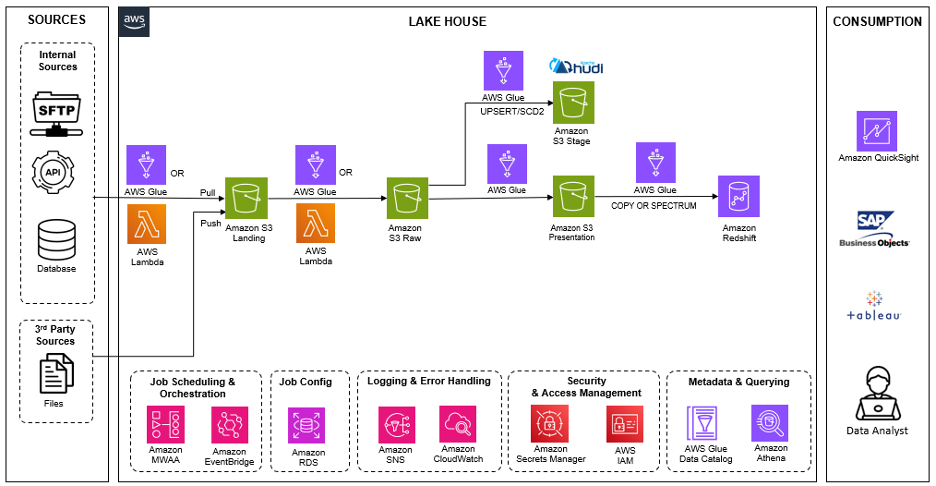

In [166]:
show_img("images/lake_house.png")

In [165]:
prompt = """
Explain this architecture diagram. Identify the components. 
"""
print(invoke_claude_sonnet(prompt,"images/lake_house.png"))

This architecture diagram depicts a data lake solution built on Amazon Web Services (AWS) cloud platform. The main components are:

Sources:
- Internal Sources: SFTP, API, Database
- 3rd Party Sources: Files

AWS Services:
- Amazon S3: Object storage service used for data landing zone and staging
- AWS Glue: Fully managed ETL service for data integration
- Amazon Athena: Query service to analyze data in S3 using SQL
- AWS Lake Formation: Data lake management service
- Amazon QuickSight: Cloud-based business intelligence tool for data visualization

Processing:
- AWS Glue Job: Handles data processing and transformation
- Amazon EMR: Managed Hadoop/Spark cluster for big data processing

Orchestration & Management:
- AWS Step Functions: Serverless workflow orchestration service
- Amazon SQS: Message queuing service for job scheduling
- AWS CloudWatch: Monitoring and logging service
- AWS Secrets Manager: Securely stores and manages credentials
- AWS IAM: Identity and Access Management for

### Analysis of Industrial piping & equipment diagram 

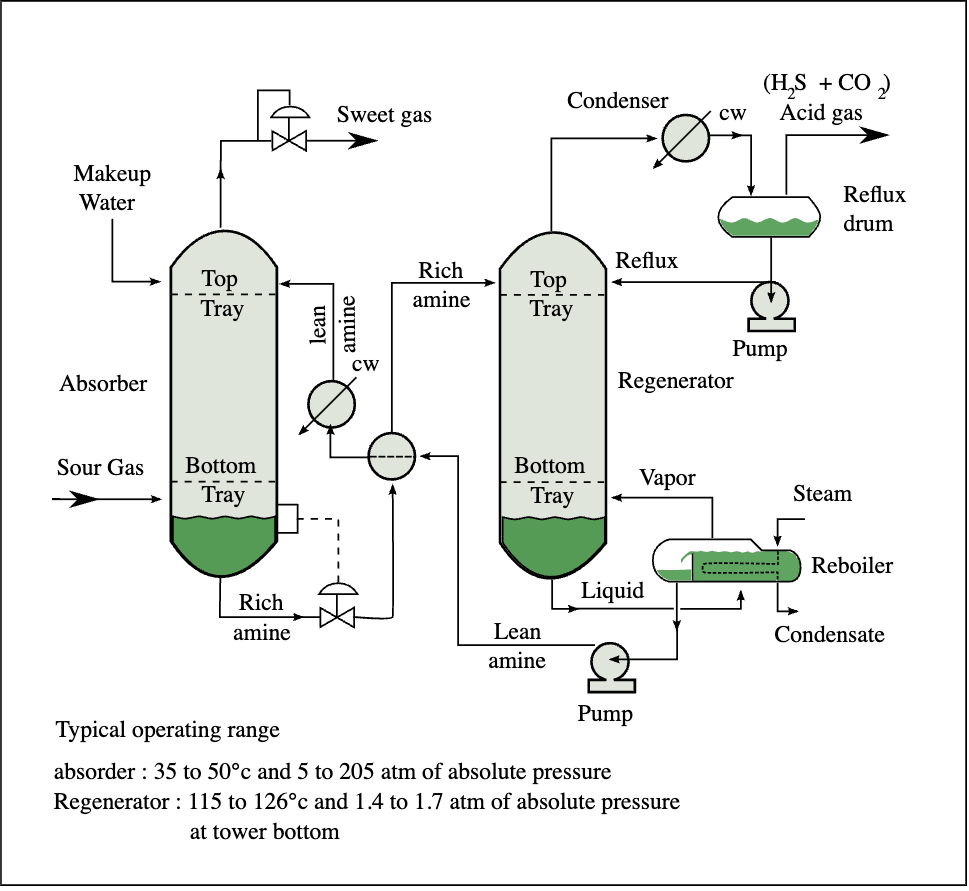

In [40]:
show_img("images/amine_treating.png")

In [31]:
prompt = """
Describe the attached diagram
"""
print(invoke_claude_sonnet(prompt,"images/amine_treating.png"))

The image depicts a typical process flow diagram for an amine gas treating unit used for removing acid gases like hydrogen sulfide (H2S) and carbon dioxide (CO2) from sour natural gas streams. The main components shown are:

1. Absorber: A tall vertical column where the sour gas enters at the bottom and contacts the lean amine solution flowing down from the top tray. The rich amine solution laden with absorbed acid gases exits from the bottom tray.

2. Rich Amine: The amine solution rich in absorbed acid gases.

3. Condenser: Cools and condenses the acid gas vapors from the regenerator.

4. Reflux Drum: Receives the condensed acid gas and reflux from the top tray of the regenerator.

5. Regenerator: A vertical column where the rich amine solution is heated to release the absorbed acid gases as vapor from the top tray. The lean amine solution exits from the bottom tray.

6. Reboiler: A heat exchanger that provides the heat required to regenerate the lean amine solution by vaporizing and

### Identify components & extract flow as JSON

In [70]:
prompt = """
        Identify the components of the flow from the diagram and how they are connected from the flow perspective. 
        Output the process flow as a json object that provides the direction of the flow between the components. 
        example
        {
            "top_tray" : {"description" : "Top tray of abosorber", "from" : ["sweet_gas"], "to" : ["lean_amine"]}
        }
        Also extract any additional text in the diagram. Restrict the components list and the direction of the flow to the diagram. Do not add anything that is not in explicitly represented in the diagram
        """
print(invoke_claude_sonnet(prompt,"images/amine_treating.png"))

{
  "sweet_gas": {
    "description": "Sweet gas",
    "to": ["condenser"]
  },
  "makeup_water": {
    "description": "Makeup Water",
    "to": ["top_tray"]
  },
  "sour_gas": {
    "description": "Sour Gas",
    "to": ["bottom_tray"]
  },
  "top_tray": {
    "description": "Top Tray",
    "from": ["makeup_water"],
    "to": ["lean_amine"]
  },
  "bottom_tray": {
    "description": "Bottom Tray",
    "from": ["sour_gas"],
    "to": ["rich_amine"]
  },
  "rich_amine": {
    "description": "Rich amine",
    "from": ["bottom_tray"],
    "to": ["top_tray"]
  },
  "lean_amine": {
    "description": "Lean amine",
    "from": ["top_tray", "pump"],
    "to": ["rich_amine"]
  },
  "condenser": {
    "description": "Condenser",
    "from": ["sweet_gas"],
    "to": ["reflux_drum", "acid_gas"]
  },
  "reflux_drum": {
    "description": "Reflux drum",
    "from": ["condenser"]
  },
  "top_tray_regenerator": {
    "description": "Top Tray",
    "from": ["rich_amine"],
    "to": ["pump", "bottom_tra

In [162]:
prompt = """
Create a Python code that generates a block diagram with directions of the process flow captured in this diagram. 
Use graphviz to generate the diagram. 
Set view=False in the call to Digraph's render function and diagram name should be amine_flow.png
The python code will be rendered in a Jupyter notebook. 
Output should contain only code, skip the preamble and any comments about generated code
     """
gen_code = invoke_claude_sonnet(prompt,"images/amine_treating.png")

In [163]:
print_md(f"```\n{gen_code}\n```")

```
from graphviz import Digraph

dot = Digraph(comment='Amine Flow')

dot.node('Makeup Water', shape='box')
dot.node('Sweet gas', shape='box')
dot.node('Top Tray', shape='box')
dot.node('Bottom Tray', shape='box')
dot.node('Absorber', shape='box')
dot.node('Rich amine', shape='box')
dot.node('Lean amine', shape='box')
dot.node('Condenser', shape='box')
dot.node('Reflux drum', shape='box')
dot.node('Reflux Tray', shape='box')
dot.node('Bottom Tray', shape='box')
dot.node('Regenerator', shape='box')
dot.node('Vapor', shape='box')
dot.node('Liquid', shape='box')
dot.node('Lean amine', shape='box')
dot.node('Reboiler', shape='box')
dot.node('Condensate', shape='box')
dot.node('Acid gas', shape='box')
dot.node('Sour Gas', shape='box')
dot.node('Steam', shape='box')

dot.edge('Makeup Water', 'Top Tray')
dot.edge('Sweet gas', 'Top Tray')
dot.edge('Top Tray', 'Bottom Tray')
dot.edge('Bottom Tray', 'Rich amine')
dot.edge('Rich amine', 'Lean amine')
dot.edge('Lean amine', 'Condenser')
dot.edge('Condenser', 'Reflux drum')
dot.edge('Reflux drum', 'Reflux Tray')
dot.edge('Reflux Tray', 'Bottom Tray')
dot.edge('Bottom Tray', 'Vapor')
dot.edge('Bottom Tray', 'Liquid')
dot.edge('Liquid', 'Lean amine')
dot.edge('Vapor', 'Reboiler')
dot.edge('Reboiler', 'Condensate')
dot.edge('Reboiler', 'Steam')
dot.edge('Reflux drum', 'Acid gas')
dot.edge('Sour Gas', 'Absorber')

dot.render('amine_flow.png', view=False)
```

#### Execute the code generated

In [164]:
exec(gen_code)

### Analysis of chart- Boiling point vs molar mass

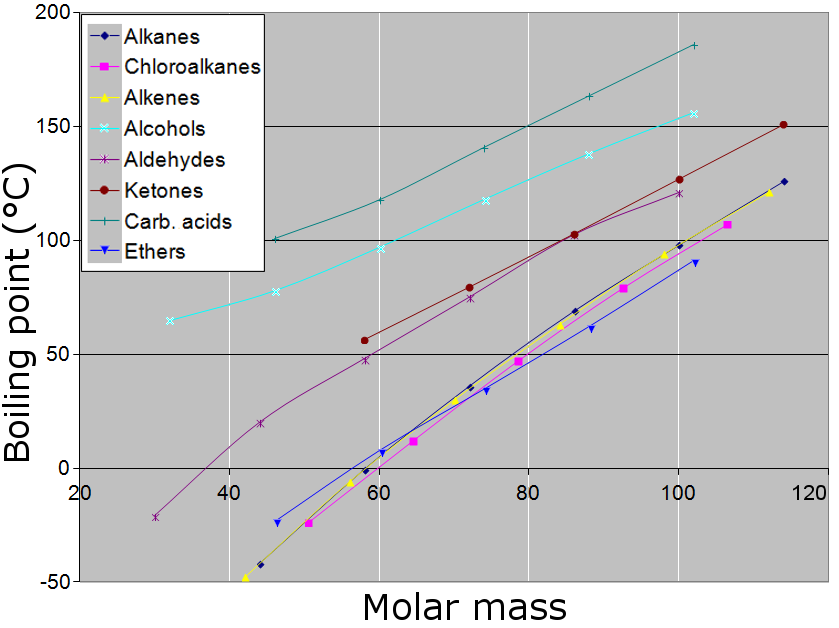

In [41]:
show_img("images/Boiling_point_vs_molar_mass_graph.png")

In [43]:
prompt = """
From this chart, compare the characteristics of Ethers and Alcohols. 
Cite some examples in your assessment 
     """
print(invoke_claude_sonnet(prompt,"images/Boiling_point_vs_molar_mass_graph.png"))

Based on the chart, we can compare the characteristics of ethers and alcohols in terms of their boiling points relative to their molar masses.

Ethers, represented by the yellow line, exhibit lower boiling points compared to alcohols (represented by the light blue line) across the range of molar masses shown. This suggests that ethers are generally more volatile and have weaker intermolecular attractions compared to alcohols of similar molar masses.

For example, at a molar mass around 60, the boiling point of an ether compound is approximately 40°C, while the boiling point of an alcohol compound with a similar molar mass is around 80°C, indicating a higher boiling point for the alcohol.

Some specific examples of ethers and alcohols that can be compared from the chart include:

1. Ether with molar mass around 60 (e.g., diethyl ether, CH3CH2OCH2CH3) has a boiling point around 40°C.
2. Alcohol with molar mass around 60 (e.g., 1-propanol, CH3CH2CH2OH) has a boiling point around 80°C.

Th

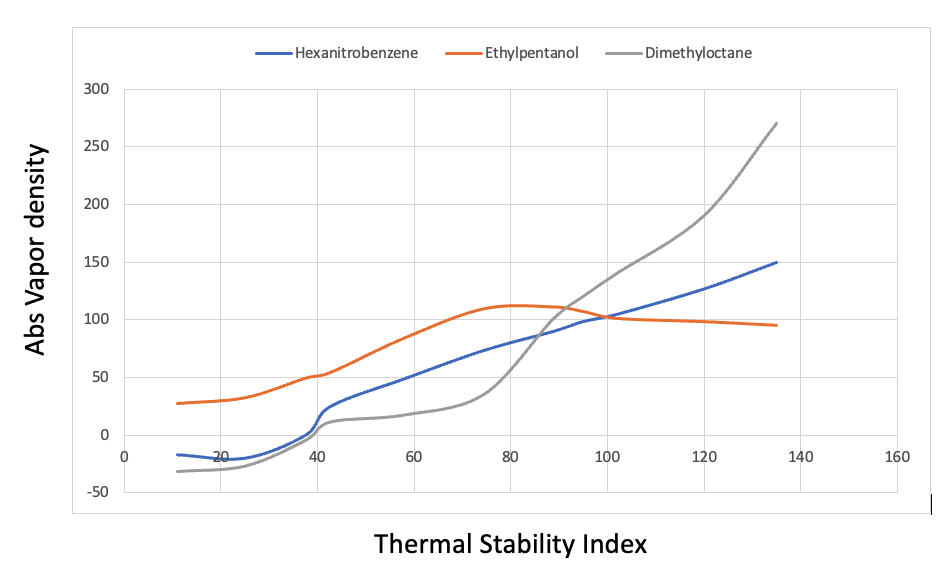

In [128]:
show_img("images/boiling_points_fictitious.png")

In [130]:
prompt = """
From this chart, compare the characteristics of organic compounds. How does the vapor density vary
     """
print(invoke_claude_sonnet(prompt,"images/boiling_points_fictitious.png"))

Based on the chart, the vapor density (labeled as "Abs Vapor density") varies differently for the three organic compounds shown:

1. Hexanitrobenzene (orange line): The vapor density increases relatively slowly as the Thermal Stability Index increases from 0 to around 100, after which it starts rising more steeply.

2. Ethylpentanol (blue line): The vapor density remains low until a Thermal Stability Index of around 60, then it starts increasing more rapidly in an upward curve.

3. Dimethyloctane (green line): The vapor density shows the steepest rise among the three compounds, increasing very sharply as the Thermal Stability Index increases beyond around 100.

So in summary, Dimethyloctane exhibits the highest vapor density increase with increasing Thermal Stability Index, followed by Ethylpentanol and then Hexanitrobenzene showing the slowest vapor density increase over the given range of Thermal Stability Index values.


## Predictive maintenance- detecting damage

Here we evalute Claude Sonnet's capabilities for predictive maintenance. We can use the model to detect damages such as dents and scratches on surfaces like automotive bodies.

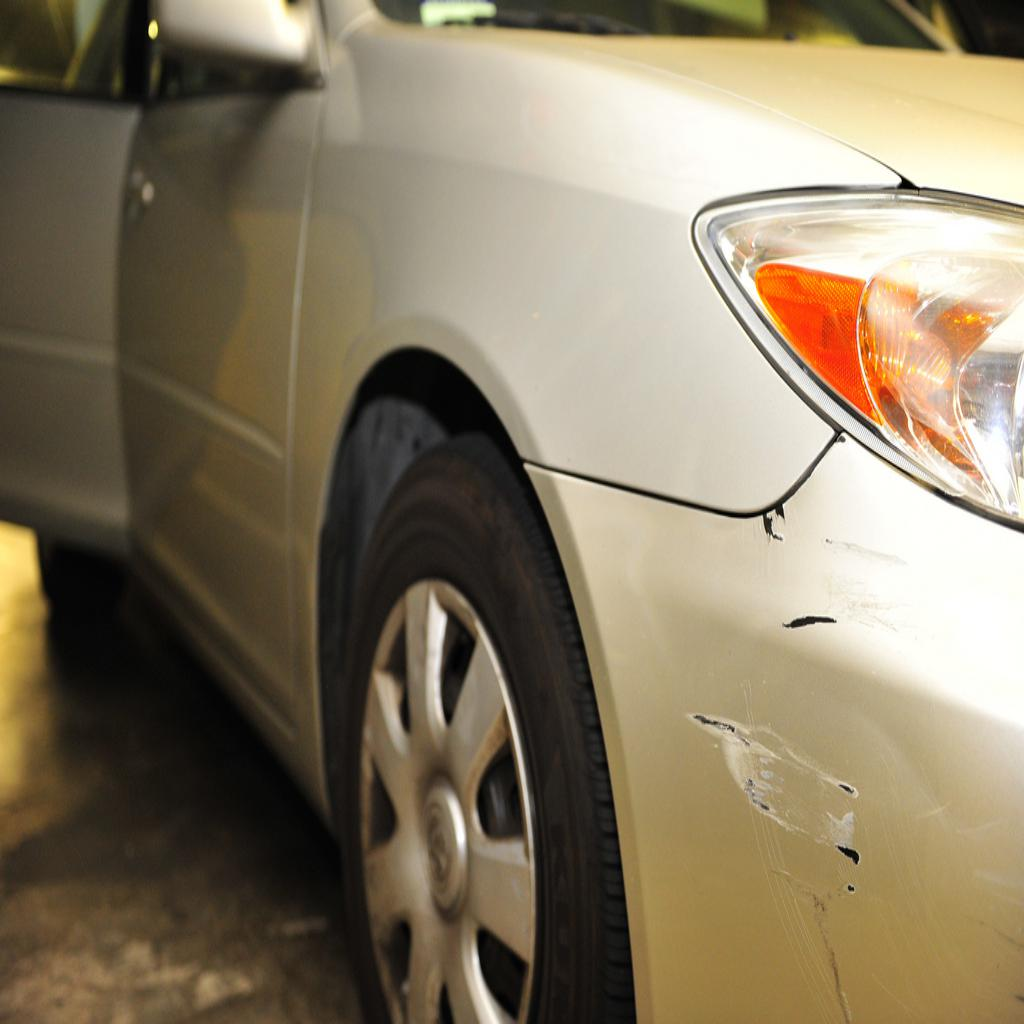

In [94]:
show_img("images/carwithdent.jpeg")

In [95]:
prompt = """
Do you observe any damage, scratch or dent in this car? If so, provide description on where the damage is.
     """
print(invoke_claude_sonnet(prompt,"images/carwithdent.jpeg"))

Yes, the image shows some damage and scratches on the side of the car near the front wheel well area. There appear to be several noticeable scratches or dents in the white paint along the side body panel right behind the front wheel and leading edge of the driver's side door.


## Multi modal RAG

With Claude Sonnet, we can build a powerful solution for integrating image information into retrieval-augmented generation (RAG) applications. By leveraging its multimodal capabilities, Claude Sonnet can produce concise text summaries from images, which can then be embedded and stored alongside raw text content in a vector database like Chroma. We will ingest multi modal embeddings generated using Titan into the vector store.  During retrieval, both the image summaries and text chunks are fetched, allowing Claude Sonnet to synthesize answers by jointly considering the raw images and textual information. This approach ensures that the valuable insights captured in images are not lost, enhancing the overall quality and comprehensiveness of the generated responses.

<img src="images/multi-modal-rag.png" width=550>

Images used in this section are extracted from https://mmlab.ie.cuhk.edu.hk/datasets/comp_cars/

In [160]:
import time, uuid
import chromadb

def describe_image(image_path):
    prompt = """ You are an assistant tasked with summarizing car parts images for retrieval. 
                 These summaries will be embedded and used to retrieve the raw image. Give a concise summary of the image that is well optimized for retrieval.
                 Include the model, make and description of the part
             """
    return invoke_claude_sonnet(prompt,image_path)

def embed_img_text(txt=None,imgbase64=None):
    body = {}
    if txt:
        body = {"inputText":txt}
    if imgbase64:
        body["inputImage"] = imgbase64
    body = json.dumps(body)
    accept = "application/json"
    contentType = "application/json"

    response = br.invoke_model(
        body=body,modelId=titan_embed_model_id,accept=accept, contentType=contentType
    )

    response_body = json.loads(response.get("body").read())
    return response_body.get("embedding")

def search_vector_store(collection,query_text=None,query_image=None,n=2,threshold=0.8):
    imagebase64 = None
    if query_image:
        imagebase64 = img2base64(query_image)
    search_embeddings = embed_img_text(query_text,imagebase64)
    search_results = collection.query(query_embeddings=search_embeddings,n_results=n)
    if search_results['distances'][0][0] > threshold:
        search_results = {}
    return search_results

def query_claude_with_context_images(collection,query_text=None,query_image=None):
    if query_image:
        search_results = search_vector_store(collection,query_text=None, query_image=query_image)
    else:
        search_results = search_vector_store(collection,query_text=query_text)
    matching_images = []
    matching_docs = []
    
    if "metadatas" in search_results and len(search_results["metadatas"]) > 0:
        matching_images = [k["imagepath"] for k in search_results["metadatas"][0]]
    if "documents" in search_results:
        for i in range(len(search_results["documents"])):
            matching_docs.append(f"Matching inventory image description: {search_results['documents'][0][i]}, Matching score: {search_results['distances'][0][i]}")

    prompt = """ You are an expert with car parts. You provide assistance to user queries via text or image or both based. In addition to user query you will be be given similar images from our inventory.
                 You analyze the user query (text and/or image) with the inventory images and provide a response pertaining to user query. 
                 Your analysis should be restricted to the context provided. Provide rationale for your analysis. 
                 Format your response as json with analysis and rationale as keys.  
             """
    if query_text:
        prompt += f"\nUser query: {query_text}"

    matching_docs = [prompt] + matching_docs
    
    if query_image:
        matching_images = [query_image] + matching_images

    return invoke_claude_sonnet_multi(matching_docs,matching_images)

In [133]:
car_desc_file = "car_parts_description.json"
car_parts_external = "images/car_parts/external"
car_parts_internal = "images/car_parts/internal"
car_parts_test = "images/car_parts/test"

if os.path.isfile(car_desc_file): #if file exists already
    with open(car_desc_file, 'r') as f:
        car_parts_descriptions = json.load(f)
else: #Create the file
    car_parts_descriptions = {}
    exts = [f"{car_parts_external}/{f}"  for f in os.listdir(car_parts_external)]
    ints = [f"{car_parts_internal}/{f}"  for f in os.listdir(car_parts_internal)]
    imgs = [f for f in (exts + ints) if os.path.isfile(f)]
    for f in imgs:
        car_parts_descriptions[f] = describe_image(f)
        time.sleep(2)
    with open(car_desc_file, "w") as f: 
            json.dump(car_parts_descriptions, f)

In [134]:
embeddings = []
image_paths = list(car_parts_descriptions.keys())
image_descs = list(car_parts_descriptions.values())
ids = []
for k,v in car_parts_descriptions.items():
    embeddings.append(embed_img_text(v,img2base64(k)))
    ids.append(str(uuid.uuid4()))

In [135]:
chroma_client = chromadb.PersistentClient(path="localdb")
coll_name = "auto-parts"

#Remove any existing collection
try:
    chroma_client.delete_collection(name=coll_name)
except:
    pass

vec_db=chroma_client.get_or_create_collection(name=coll_name)

In [136]:
vec_db.add(
    embeddings = embeddings,
    documents = image_descs,
    metadatas = [{"imagepath":f } for f in image_paths],
    ids = ids
)

In [137]:
search_results = search_vector_store(vec_db,"manual transmission gear shift")
search_results

{'ids': [['cb70c457-3c96-4dfe-8da0-81282dda2462',
   '7998ae7b-4561-4ea2-8228-1fc8f4f4d756']],
 'distances': [[0.6836967551952161, 0.7218620481089106]],
 'metadatas': [[{'imagepath': 'images/car_parts/internal/00b0964255e746.jpg'},
   {'imagepath': 'images/car_parts/internal/00c3a15808518f.jpg'}]],
 'embeddings': None,
 'documents': [["This image depicts a manual gear shift lever or stick shift from a vehicle's interior. The gear shift knob is made of chrome or metallic material and has the gears numbered (likely 1 through 5 or 6) engraved on the top. The gear boot or cover surrounding the base of the shift lever appears to be made of black leather or vinyl material. The image provides a close-up view of this manual transmission component which allows the driver to manually change gears in the vehicle.",
   "This image shows the center console and gear shift of a vehicle's interior. The gear shift lever is in the manual transmission position, and the console includes various buttons an

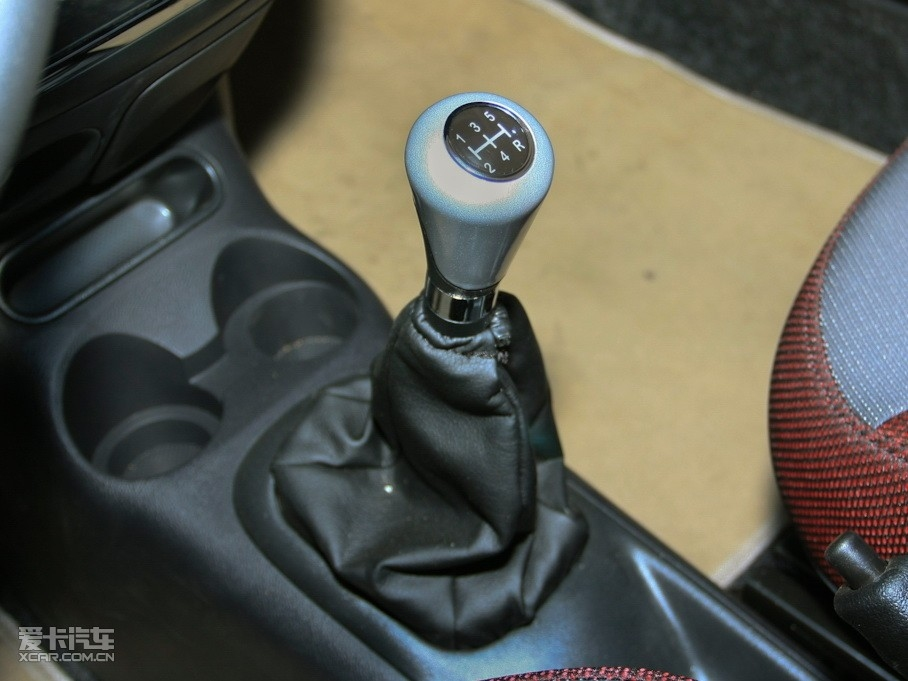

In [138]:
show_img([k['imagepath'] for k in search_results["metadatas"][0]][0])

In [139]:
search_results = search_vector_store(vec_db,None, f"{car_parts_test}/cute_cat.jpg")
search_results

{}

### Ask a question with an image and a text

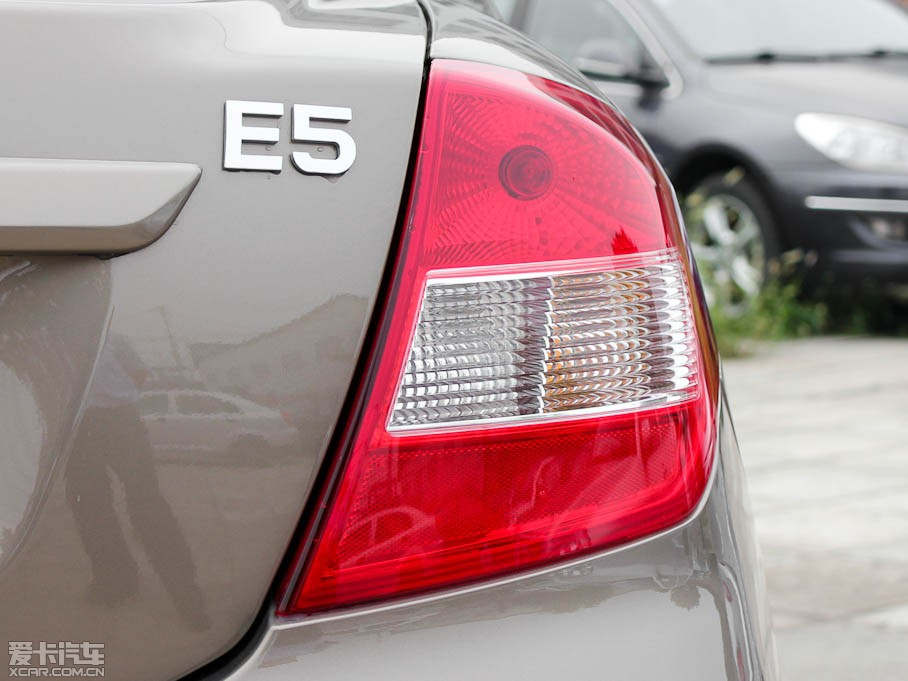

In [140]:
show_img(f"{car_parts_test}/taillights.jpg")

In [141]:
query_response = query_claude_with_context_images(vec_db,"Is this a fog light?", f"{car_parts_test}/taillights.jpg")
print(query_response)

{
"analysis": "No, the image does not show a fog light. The images depict the rear taillight assembly of a Toyota Vaggio car model.",
"rationale": "The description provided for the matching inventory images clearly states that they show the rear taillight assembly with distinctive curved LED taillights and styling elements specific to the Toyota Vaggio model. Fog lights are typically mounted on the front of a vehicle, closer to the ground, to provide better illumination and visibility in foggy conditions. Therefore, based on the information given, these images are not of a fog light but rather the rear taillights of a Toyota car."
}


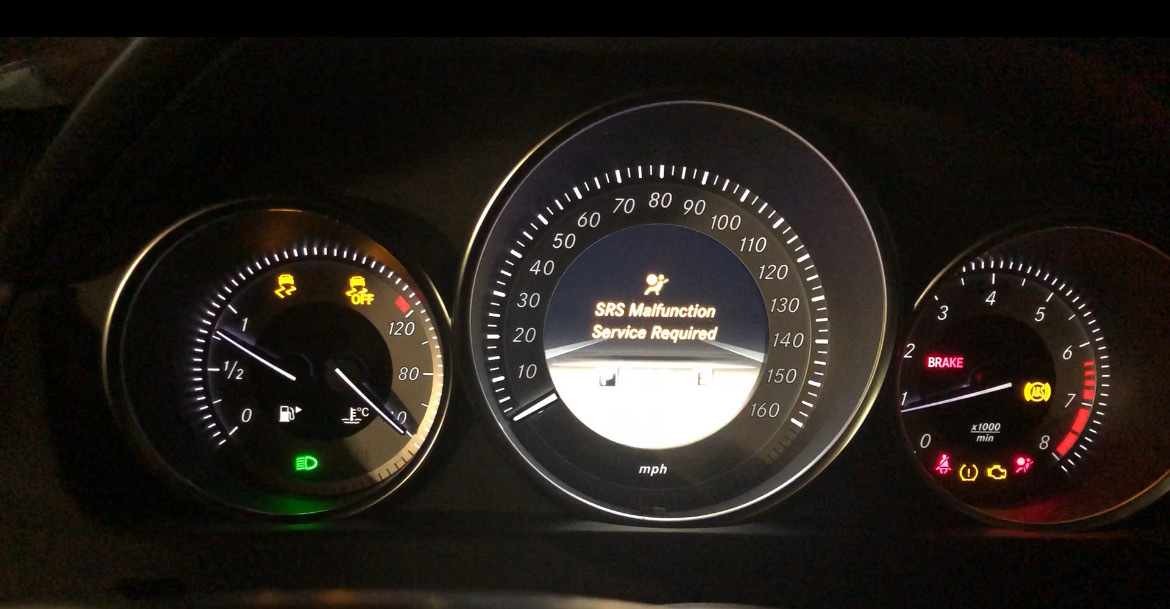

In [149]:
show_img(f"{car_parts_test}/srs.jpg")

In [151]:
query_response = query_claude_with_context_images(vec_db,"What's wrong with my car. What is the suggested resolution?", f"{car_parts_test}/srs.jpg")
print(query_response)

{
"analysis": "The image shows that the instrument cluster or dashboard display of the vehicle is indicating a 'SRS Malfunction Service Required' warning. Additionally, the 'BRAKE' warning light is illuminated on the rightmost gauge. This suggests that there are issues with the vehicle's Supplemental Restraint System (SRS) and brake system.",

"rationale": "The 'SRS Malfunction Service Required' warning typically indicates a problem with the vehicle's airbag system or related safety components. This could be due to a faulty sensor, wiring issue, or other malfunction in the SRS. The illuminated 'BRAKE' warning light indicates a problem with the brake system, which could be related to low brake fluid, worn brake pads, or an issue with the brake components or hydraulic system. Both of these warnings need to be addressed promptly as they relate to critical safety systems in the vehicle."
}


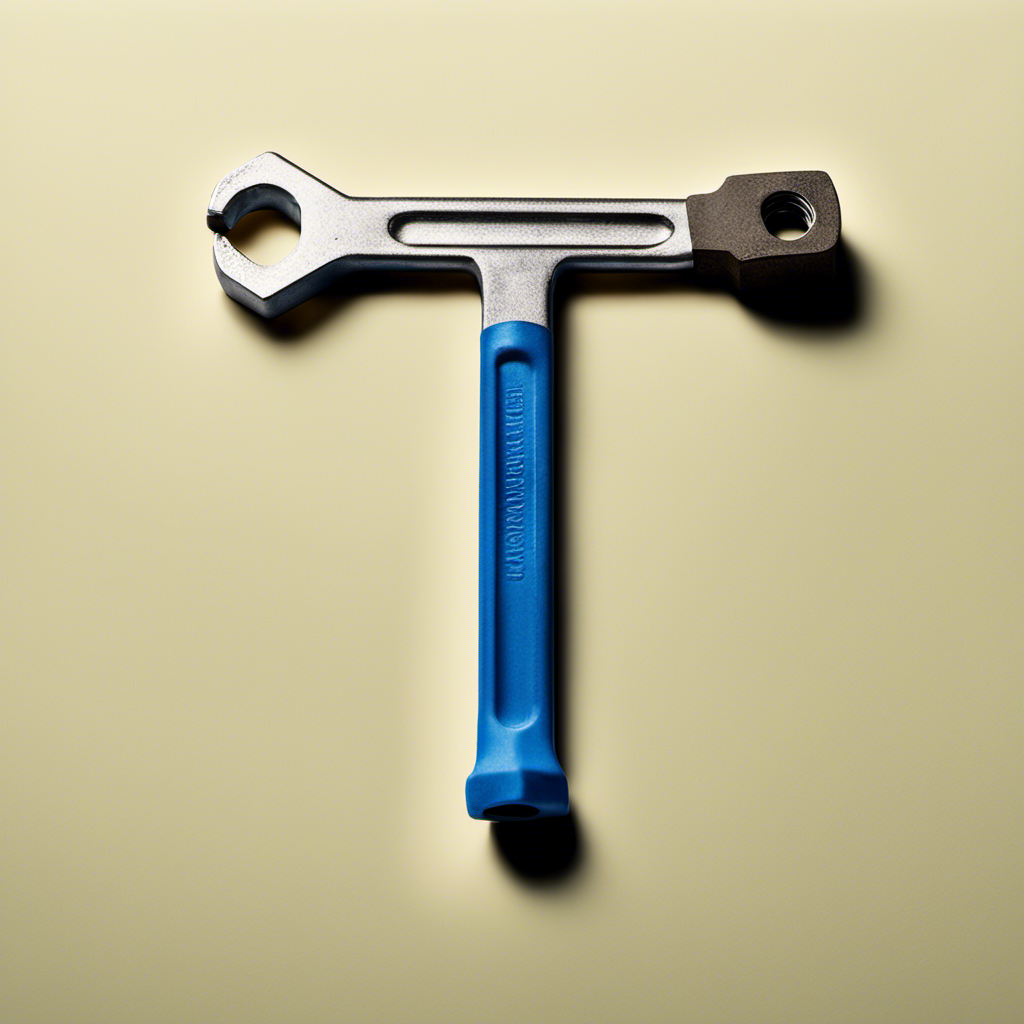

In [156]:
show_img(f"{car_parts_test}/screw.png")

In [157]:
query_response = query_claude_with_context_images(vec_db,"I found this outside of my car. Is this a car part?", f"{car_parts_test}/screw.png")
print(query_response)

{
"analysis": "No, the object shown in the image is not a car part. It appears to be a wrench or spanner, which is a hand tool used for gripping and turning nuts, bolts, and other mechanical components.",
"rationale": "While wrenches and other tools are essential for performing automotive repairs and maintenance, they are not parts that are permanently installed on a vehicle. The image depicts a common open-ended wrench with a blue plastic handle and a metal body with openings of different sizes on each end to fit different sizes of nuts and bolts. Finding a loose wrench outside of your car likely means that it was accidentally left there after working on the vehicle."
}


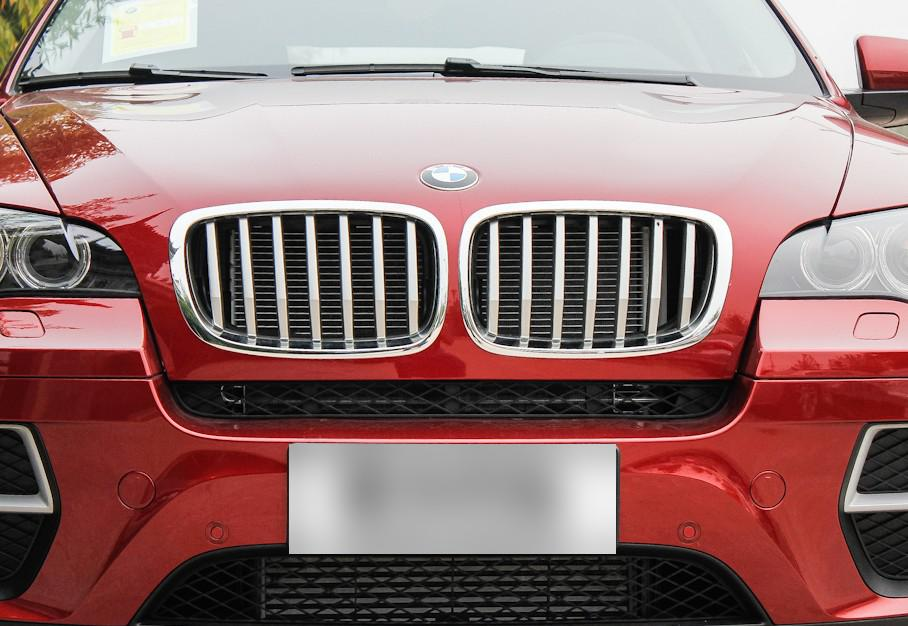

In [159]:
show_img(f"{car_parts_test}/bmw.jpg")

In [158]:
query_response = query_claude_with_context_images(vec_db,"does my car have navigation system?", f"{car_parts_test}/bmw.jpg")
print(query_response)

{
"analysis": "The provided images only show the front grille and bumper area of BMW cars. There is no information or visual evidence to determine whether these specific vehicles have a built-in navigation system or not.",
"rationale": "The question 'does my car have a navigation system?' cannot be answered definitively based solely on the given images, as they do not depict the interior dashboard or infotainment system of the cars where a navigation system would typically be present. The iconic BMW kidney grille design alone does not provide any indication about the availability of a navigation system in that particular vehicle model or trim level."
}


### Input just an image

In [148]:
query_response = query_claude_with_context_images(vec_db,None, f"{car_parts_test}/taillights.jpg")
print(query_response)

{
"analysis": "The query image appears to show the rear taillight assembly of a BMW 5 Series sedan, specifically the E5 model designation visible on the trunk lid. The taillight has a distinctive multi-lens design typical of modern BMW models, with separate red and clear sections for the brake lights, turn signals, and reverse lights. The body panel is painted in a silver/gray color.",
"rationale": "By comparing the details in the user's query image with the inventory images provided, there are clear similarities in the taillight design and 'E5' model badging, indicating this is a BMW 5 Series sedan rather than the Toyota Vaggio model mentioned in the inventory description. The curved multi-lens taillight layout and gray body color match the user's image, while the inventory images show a different taillight shape, deeper maroon color, and 'Vaggio' branding that does not align with the query."
}
